# Main CNN model for bat call classification

### **TO RUN THIS FILE**, just press the "restart&execute" button, and when the kernel dies, restart the notebook process, go to the `exit()` cell and execute all cells after that one

In [34]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# dont use gpu [for M1/M2 Metal, cause it cant handle [presumably] Dropout Layers too well], comment out if you want to use GPU
tf.config.set_visible_devices([], 'GPU') 
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
import gc
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
from sklearn.utils import shuffle

In [35]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
smote = SMOTE()
adasyn = ADASYN()

X, y = resample(adasyn)

# Kombination aus over und undersampling
smoteenn = SMOTEENN()
smotettomek = SMOTETomek()

ADASYN():  2    2179
0    2104
3    2099
5    2097
4    2082
1    2018
dtype: Int64


In [36]:
image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1
X = X / 255.
X = X.reshape((-1,) + image_shape)

Image has shape (65, 100, 3)


In [37]:
kfold = KFold(n_splits=10, shuffle=True)

tf.keras.utils.set_random_seed(1)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

In [38]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32
dropout_rate = 0.3 # https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets interessant bzgl oberfitting
weight_decay_alpha = 0.015

def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=image_shape))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))

    return model

In [39]:
def fit_model(model, X_train, y_train, worker=8):
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        workers=worker, # workers are number of cores
        callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
        validation_split=0.2,
        verbose=1)

    return history

In [40]:
end_step = np.ceil(X.shape[0] / batch_size).astype(np.int32) * epochs

pruning_params = {
    # In this example, you start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity.
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=end_step)}

model = create_model()
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

In [41]:
# for confusion_matrix
true_labels = list()
pred_labels = list()
train_accuracies = list()
test_accuracies = list()
val_accuracies = list()
train_losses = list()
val_losses = list()
test_losses = list()

for train_indezes, test_indezes in kfold.split(X, y):
    K.clear_session()
    X_train, y_train = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[train_indezes])
    X_test, y_test = tf.convert_to_tensor(X[test_indezes]), tf.convert_to_tensor(y[test_indezes])
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = fit_model(model, X_train, y_train)

    # for confusion matrix
    predictions = np.argmax(model.predict(X_test), axis=-1)
    true_labels.extend(y_test)
    pred_labels.extend(predictions)

    # for accuracy curves
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])

    # for loss curves
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

    loss, accuracy = model.evaluate(X_test, y_test)
    test_accuracies.append(accuracy)
    test_losses.append(loss)

KeyboardInterrupt: 

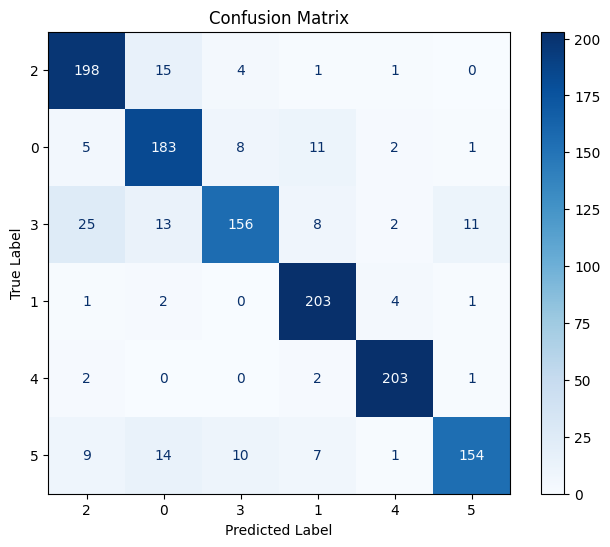

In [ ]:
confusion_matrix = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix, display_labels=classes)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

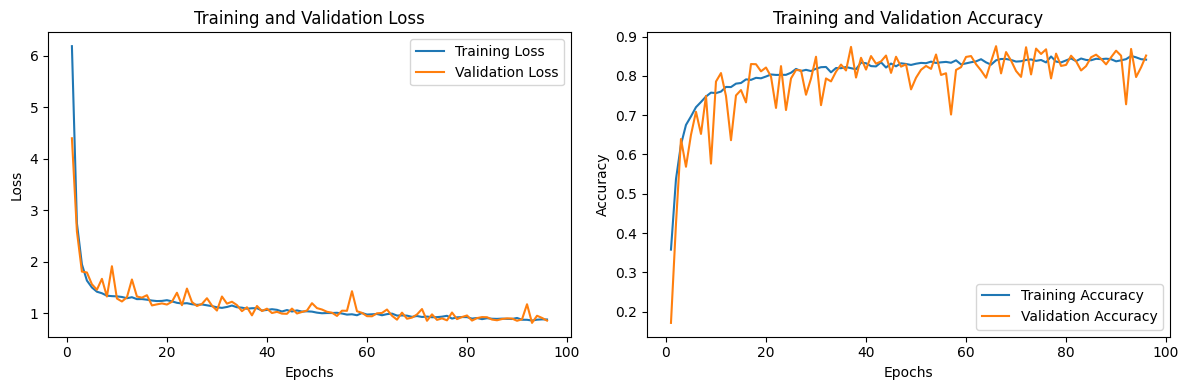

In [ ]:
# Plotting the training and validation curves
epochs = len(train_losses)
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("./cnn_files/loss_and_accuraccy.png")
plt.show()

In [ ]:
print(f"Test accuracy: {sum(test_accuracies) / len(test_accuracies)}")
print(f"Test loss: {sum(test_losses) / len(test_losses)}")

Test accuracy: 0.8720190525054932
Test loss: 0.8890348672866821
